In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *

%matplotlib inline
from pylab import *

rcParams['figure.figsize'] = 10, 10

font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 14}

matplotlib.rc('font', **font)

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_poi.shp"
gdf = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf.crs))

gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

point CRS: {'init': 'epsg:32613'}


,Id,comments,geometry
0,0,NEON light tarp center,POINT (-105.2449209483192 40.13056064633826)
1,0,NEON dark tarp center,POINT (-105.2450429801881 40.13055609737145)
2,0,some other target?,POINT (-105.2449348460157 40.13027956799884)
3,0,road sample east of tarps,POINT (-105.2445969512152 40.13050721903751)
4,0,4-way intersection,POINT (-105.2445888333624 40.1306683804434)


In [3]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
radiance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/RadianceH5/2019040915/*.h5')
radiance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/*.h5')

reflectance_files_april09 = glob(data_dirs[0] + '/L1/Spectrometer/ReflectanceH5/2019040915/*.h5')
reflectance_files_april10 = glob(data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/*.h5')


# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
radiance_files_VNIR_april09 = glob(data_dirs_VNIR[0] + '/*.hdr')
radiance_files_VNIR_april09 = [f[:-4] for f in radiance_files_VNIR_april09] # remove the .hdr

radiance_files_SWIR_april09 = glob(data_dirs_SWIR[0] + '/*.hdr')
radiance_files_SWIR_april09 = [f[:-4] for f in radiance_files_SWIR_april09] # remove the .hdr


In [4]:
reflectance_files_april09, radiance_files_VNIR_april09, radiance_files_SWIR_april09

(['../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163351_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_163915_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_164414_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_171839_reflectance.h5',
  '../neon_data/2019_R10C_1/L1/Spectrometer/ReflectanceH5/2019040915\\NEON_D10_R10C_DP1_20190409_172333_reflectance.h5'],
 ['../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S2',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S3',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S4',
  '../headwall_data/VNIR/TableMtn_Flight1_processed\\TM_F1_S5'],
 ['../headwall_data/SWIR/TableMtn_Flight1_processed\\TM_F1_S1',
  '../hea

In [5]:
## try to open one of the data files with xarray
neon_ind=4
if neon_ind % 2 == 0:
    fl_dir = 'NS'
else:
    fl_dir = 'EW'
    
hw_ind=1
data_file_VNIR = radiance_files_VNIR_april09[hw_ind]
data_file_SWIR = radiance_files_SWIR_april09[hw_ind]
data_file_NEON = reflectance_files_april09[neon_ind] # NEON_D10_R10C_DP1_20190409_172333_reflectance

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)
print(data_file_VNIR)

NEON ID:  R10C
../headwall_data/VNIR/TableMtn_Flight1_processed\TM_F1_S2


# Load ENVI spectral libraries

In [6]:
rad_files = glob('../spectra_samples/*_rad.txt')
hw_vnir_rad_files = [f for f in rad_files if 'hw_vnir' in f]
hw_swir_rad_files = [f for f in rad_files if 'hw_swir' in f]
neon_rad_files = [f for f in rad_files if 'neon' in f]

In [7]:
import pandas as pd

In [8]:
# pd.read_csv(neon_rad_files[0], skiprows=7, header=0, names=['wavelength', 'white_tarp', 'black_tarp', 'road1', 'road2'])
# pd.read_csv(neon_rad_files[0], skiprows=6, header=0)
pd.read_table(neon_rad_files[0], skiprows=6, header=0, index_col=None)

def read_envi_ascii_to_df(fi):
    vals=[]
    with open(fi) as f:
        for i,l in enumerate(f.readlines()):
            if i<6:
                continue
            
            
            val = [float(v) for v in l.strip().split()]
            vals.append(val)
            
    return vals

neon_rad = pd.DataFrame(read_envi_ascii_to_df(neon_rad_files[0]), columns=['wavelength', 'white_tarp', 'black_tarp', 'road1', 'road2'])
hw_vnir_rad = pd.DataFrame(read_envi_ascii_to_df(hw_vnir_rad_files[0]), columns=['wavelength', 'white_tarp', 'black_tarp', 'road1', 'road2'])
hw_swir_rad = pd.DataFrame(read_envi_ascii_to_df(hw_swir_rad_files[0]), columns=['wavelength', 'white_tarp', 'black_tarp', 'road1', 'road2'])

C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  This is separate from the ipykernel package so we can avoid doing imports until


C:\software\anaconda3\envs\eapy_gbdx\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


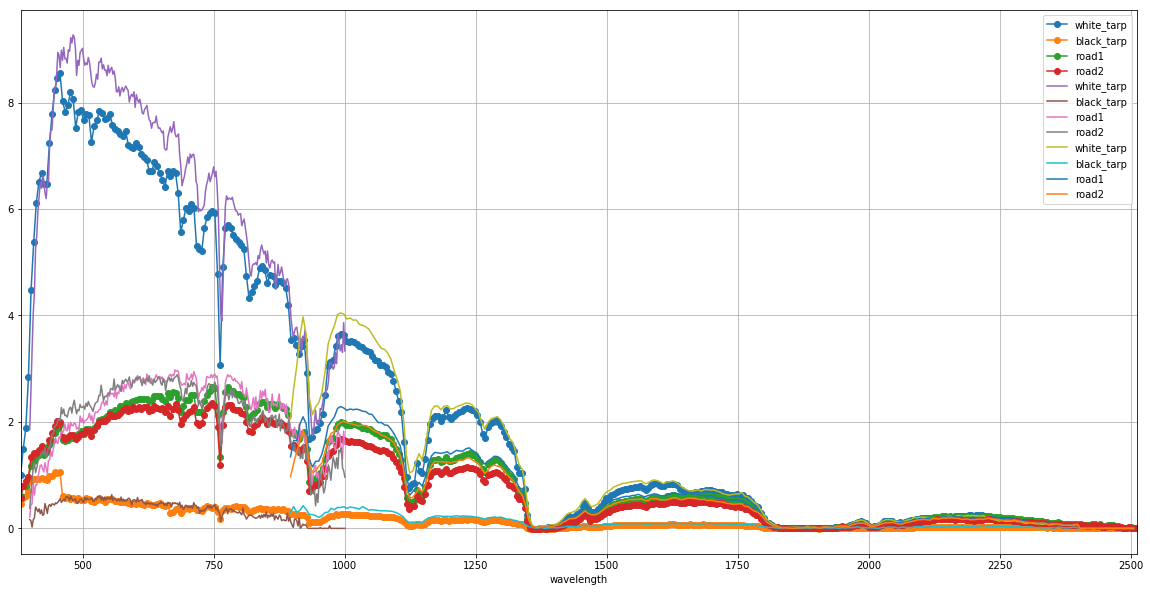

In [9]:
ax = neon_rad.plot(x='wavelength', grid=True, figsize=(20,10), marker='o', label='NEON')
hw_vnir_rad.plot(x='wavelength', grid=True, ax=ax)
hw_swir_rad.plot(x='wavelength', grid=True, ax=ax)
plt.legend()

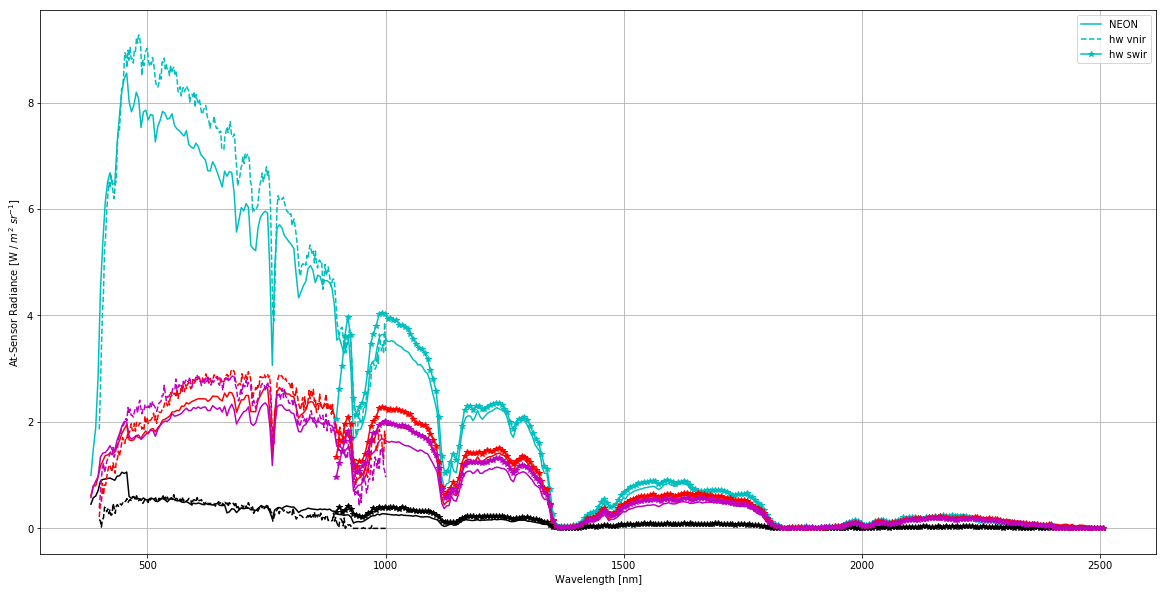

In [10]:
plt.figure(figsize=(20,10))
plt.plot(neon_rad['wavelength'], neon_rad['white_tarp'], 'c', label='NEON')
plt.plot(neon_rad['wavelength'], neon_rad['black_tarp'], 'k', label='')
plt.plot(neon_rad['wavelength'], neon_rad['road1'], 'r', label='')
plt.plot(neon_rad['wavelength'], neon_rad['road2'], 'm', label='')

plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['white_tarp'], '--c', label='hw vnir')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['black_tarp'], '--k', label='')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road1'], '--r', label='')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road2'], '--m', label='')

plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['white_tarp'], '-*c', label='hw swir')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['black_tarp'], '-*k', label='')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road1'], '-*r', label='')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road2'], '-*m', label='')

plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()

Text(0.5, 1.0, 'Bright Tarp (At-Sensor Radiance curves)')

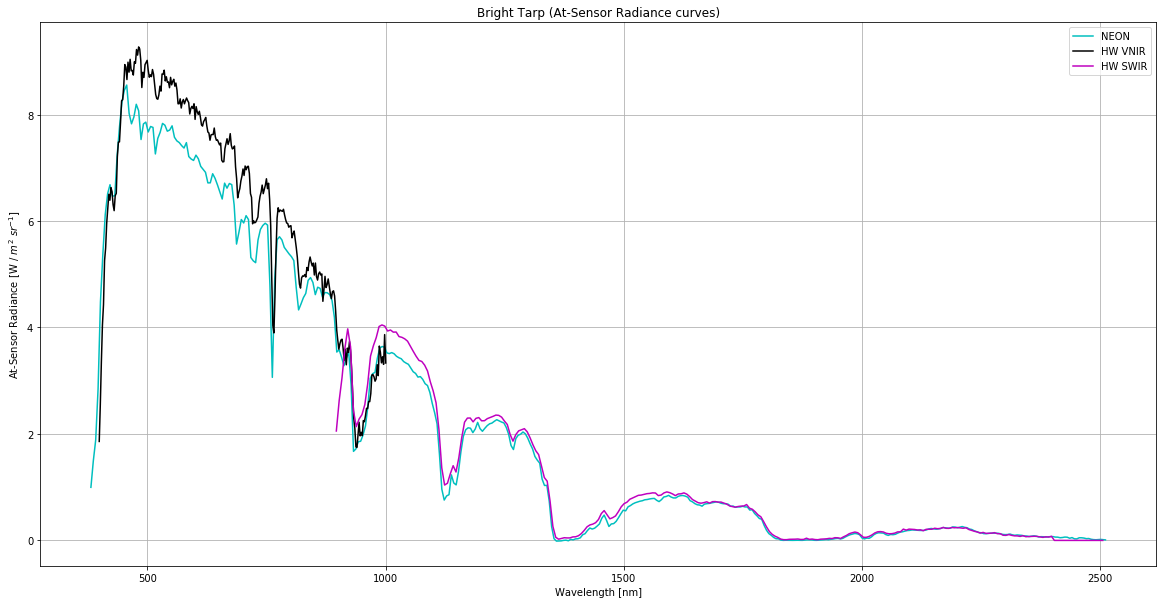

In [11]:
plt.figure(figsize=(20,10))
# plt.plot(neon_rad['wavelength'], neon_rad['white_tarp'], 'c', label='NEON')
# plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['white_tarp'], '--c', label='HW VNIR')
# plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['white_tarp'], '-*c', label='HW SWIR')

plt.plot(neon_rad['wavelength'], neon_rad['white_tarp'], 'c', label='NEON')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['white_tarp'], 'k', label='HW VNIR')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['white_tarp'], 'm', label='HW SWIR')

plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.title('Bright Tarp (At-Sensor Radiance curves)')

Text(0.5, 1.0, 'Dark Tarp (At-Sensor Radiance curves)')

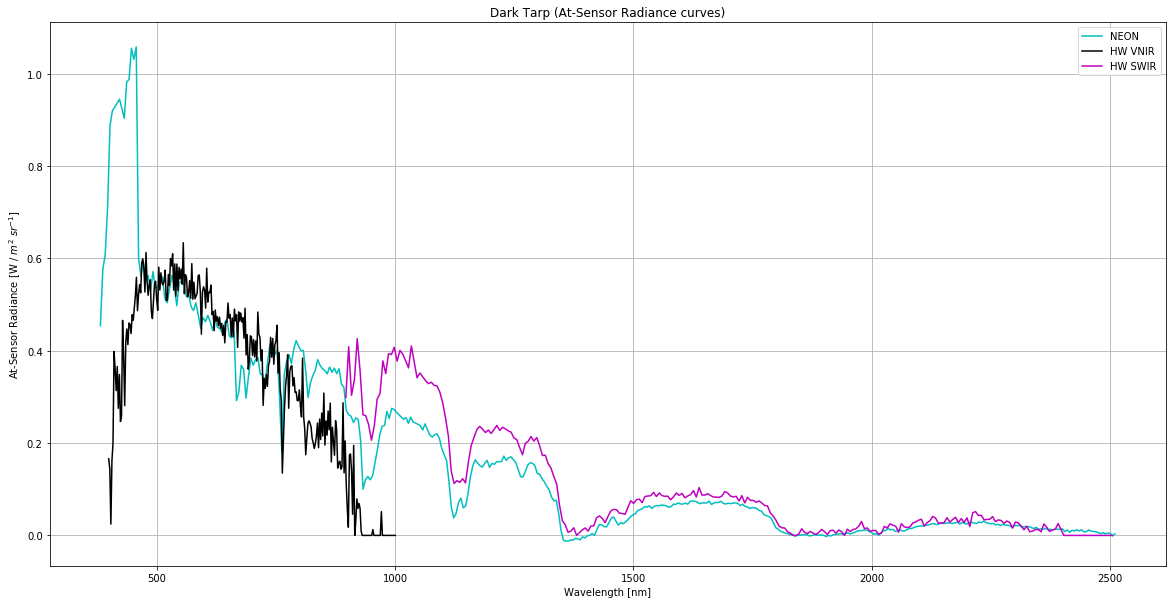

In [12]:
plt.figure(figsize=(20,10))

# plt.plot(neon_rad['wavelength'], neon_rad['black_tarp'], 'k', label='NEON')
# plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['black_tarp'], '--k', label='HW VNIR')
# plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['black_tarp'], '-*k', label='HW SWIR')

plt.plot(neon_rad['wavelength'], neon_rad['black_tarp'], 'c', label='NEON')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['black_tarp'], 'k', label='HW VNIR')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['black_tarp'], 'm', label='HW SWIR')

plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.title('Dark Tarp (At-Sensor Radiance curves)')

Text(0.5, 1.0, 'Road sample #1 (At-Sensor Radiance curves)')

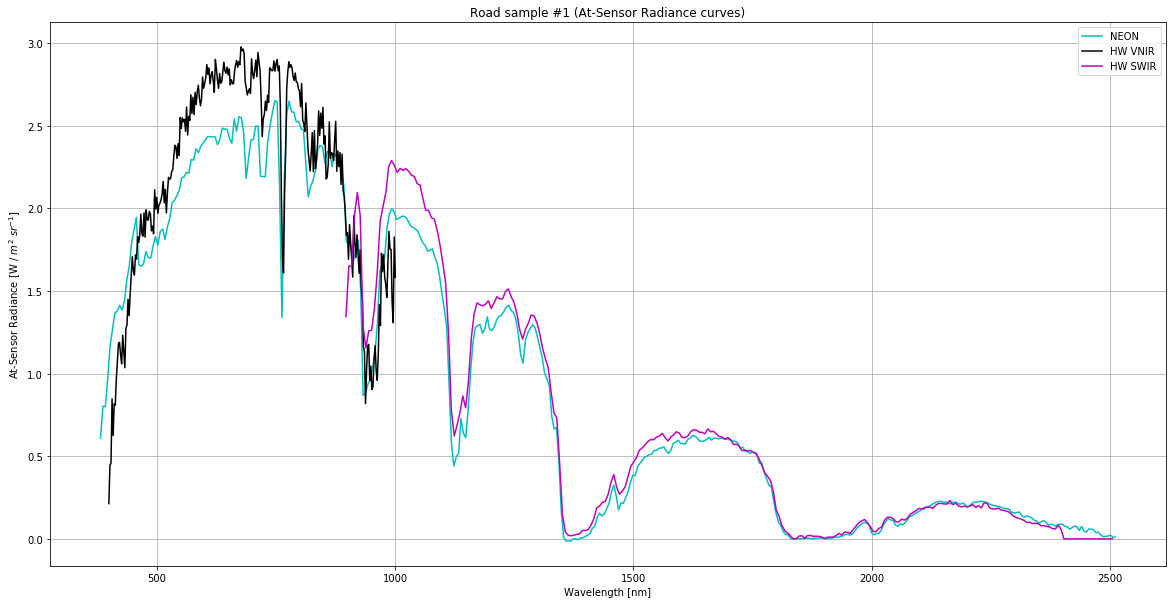

In [13]:
plt.figure(figsize=(20,10))

# plt.plot(neon_rad['wavelength'], neon_rad['road1'], 'r', label='NEON')
# plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road1'], '--r', label='HW VNIR')
# plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road1'], '-*r', label='HW SWIR')

plt.plot(neon_rad['wavelength'], neon_rad['road1'], 'c', label='NEON')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road1'], 'k', label='HW VNIR')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road1'], 'm', label='HW SWIR')

plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.title('Road sample #1 (At-Sensor Radiance curves)')

Text(0.5, 1.0, 'Road sample #2 (At-Sensor Radiance curves)')

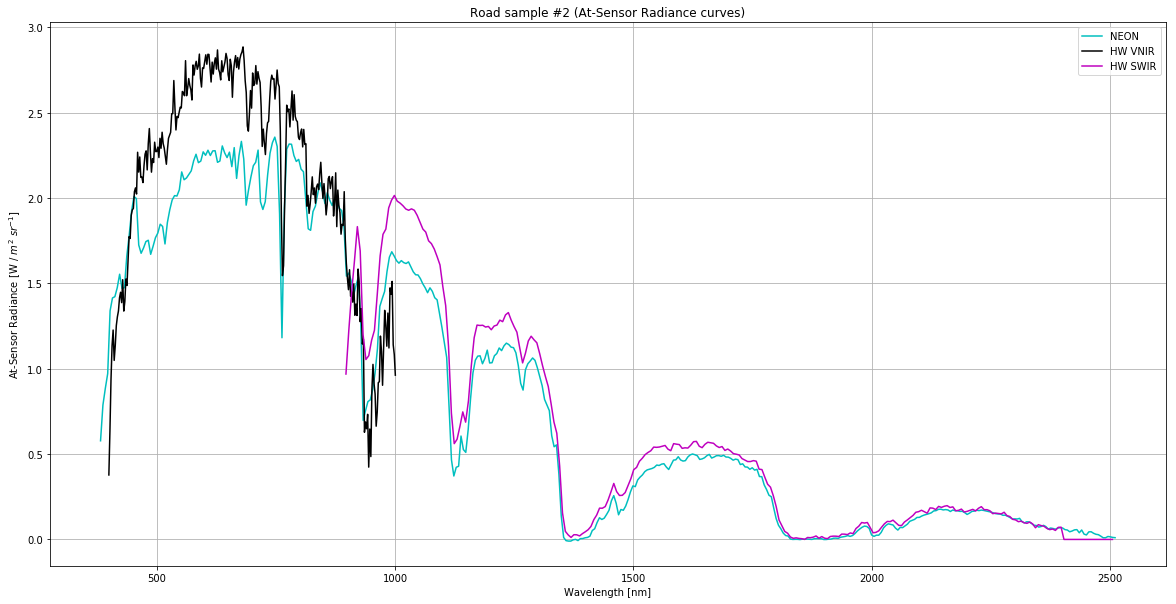

In [14]:
plt.figure(figsize=(20,10))

# plt.plot(neon_rad['wavelength'], neon_rad['road2'], 'm', label='NEON')
# plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road2'], '--m', label='HW VNIR')
# plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road2'], '-*m', label='HW SWIR')

plt.plot(neon_rad['wavelength'], neon_rad['road2'], 'c', label='NEON')
plt.plot(hw_vnir_rad['wavelength'], hw_vnir_rad['road2'], 'k', label='HW VNIR')
plt.plot(hw_swir_rad['wavelength'], hw_swir_rad['road2'], 'm', label='HW SWIR')

plt.xlabel('Wavelength [nm]')
plt.ylabel('At-Sensor Radiance [W / $m^2$ $sr^{-1}$]')
plt.grid(True)
plt.legend()
plt.title('Road sample #2 (At-Sensor Radiance curves)')

# Would like to do this with spatial data. The Geo-Corrected radiance cubes from headwall actually draw correctly when the NEON data is added first. Closer look at the header shows a rotation=90.000 parameter in the map_info, and this may no be handled correctly by GDAL.